First, let's just declare all the libraries we will be using. Nothing fancy, just usual stuff... numpy, pandas, cone optimization, plotting and visualization libraries, etc.

In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import cvxopt as opt
from cvxopt import blas, solvers
import pandas as pd

np.random.seed(123)

#Turn off progress printing
solvers.options['show_progress']=False

import plotly.plotly as py
import plotly.tools as tls
from plotly.graph_objs import *
import plotly.graph_objs as go


#This is necessary for the visualization service
import plotly
py.sign_in('linobi', 'xlupudvz62')
import cufflinks
plotly.__version__

from datetime import datetime
from zipline.utils.factory import load_bars_from_yahoo

If you want to use real data, use the cell below, otherwise skip to the next cell.

In [6]:
#starting and ending dates
end = pd.Timestamp(datetime(2016, 1, 1))
start = end - 2500* pd.tseries.offsets.BDay() #This is approximately ten years.

#Tickers to use. Be careful with the combination of signals and periods to be used...
#if some data is missing or has a weird behavior (including constant returns, like in the case of bonds or most fixed income)
#the quadratic optimizator will go to hell
data = load_bars_from_yahoo(stocks=['IBM', 'GLD', 'XOM', 'AAPL', 
                                    'MSFT', 'TLT'],
                            start=start, end=end)

return_vec = data.loc[:, :, 'price'].pct_change().dropna()

#in case you wanna take a look of the imported data:
#data.loc[:, :, 'price'].iplot(filename='prices', yTitle='price in $', world_readable=True, asDates=True)

/Users/lino/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: DeprecationWarning:

load_bars_from_yahoo is deprecated, please register a yahoo_equities data bundle instead



Now, if you want to use some artificial time series, just do it below:

In [ ]:
## Number of assets... we'll simulate the same amount of assets used above, just for the sake of it
n_assets = 6
## Number of observations... and the same size of sample
n_obs = 2500

return_vec = np.random.randn(n_assets, n_obs)

#Put the artificial series in dataframe form
return_vec = return_vec.T

One way or another you end up with a return_vec dataframe than includes the entire normalized vectors of daily returns of the signals used. We will be iterating over this vector later on in order to get the dynamic frontier.

A now, the Markowitz Cone optimization technique. It simply receives as input a set (dataframe) of time series and outputs the weights of the optimal portfolio (the one with the highest sharpe ratio) along the mean-variance (std) pairs of the entire frontier:

In [7]:
def optimal_portfolio(returns):
    n = len(returns)
    returns = np.asmatrix(returns)
    
    N = 100
    mus = [10**(5.0*t/N - 1.0) for t in range(N)]
    
    #Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))
    
    #Create constraint matrices
    G = -opt.matrix(np.eye(n))
    h = opt.matrix(0.0, (n, 1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
                  for mu in mus]
    
    ## Calculate risks and returns for frontier
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    
    ## Calculate the 2nd degree polynomial of the frontier curve
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    
    ## Calculate the optimal portfolio
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks

Now let's see if we can generate and plot the dynamic frontier. We have to find the frontier every x amount of days.

In [8]:
Period = []
Returns = []
Risks = []

#we'll try this trick to plot a nice surface
Returns_surfs = []

#we'll find the efficient frontier every 20 days
for x in range (0,120):
    
    returns_snapshot = return_vec[0 + x*20 : 250 + x*20].copy() #you need to do this stupid copy, because the optimizer needs the arrays transposed, and the dynamic nature of python will attempt to transpose the chopped array into the whole one.
    weights, ret, ris = optimal_portfolio(returns_snapshot.T)
    
    for y in range (0,len(ret)):
        Period.append(x)
    
    Returns_surfs.append(ret)
    
    Returns = Returns + ret
    Risks = Risks + ris


That's it. Now we have 120 frontiers, one for each month (approx.) of the total lenght of our time series, that is, 10 years approx. 

Plotting a nice surface with this "dynamic" frontier is problematic. This is due the fact that we only have a collection of 3D points, which is very far from being a true 3D surface. So for now we will just plot a nice scatter plot using plot.ly, a cool visualization SaaS.

In [9]:
trace1 = go.Scatter3d(
    x=Period,
    y=Risks,
    z=Returns,
    mode='markers',
    marker=dict(
        size=1,
        color=Returns,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)

data = [trace1]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='dynamic-frontier-20days-2006-2016-AAPL-MST-GLD-TLT-XOM-IBM')

We'll try to plot a surface anyway, through a "triangulation-surface" plot, though the result is ugly.

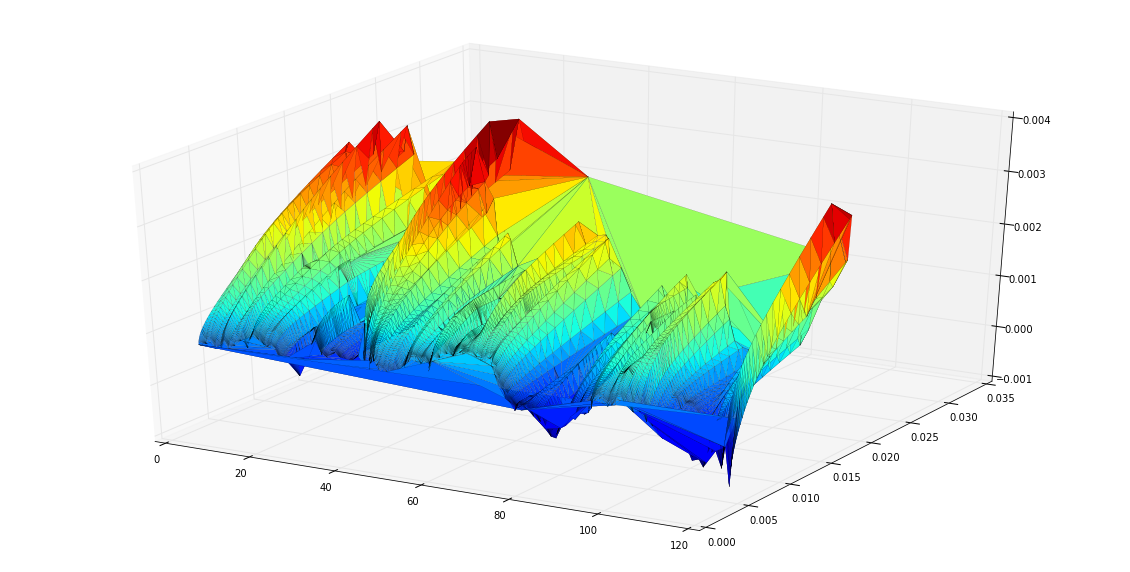

In [13]:
fig = plt.figure(figsize=(20, 10), dpi=240)
ax = fig.gca(projection='3d')
ax.plot_trisurf(Period, Risks, Returns, cmap=cm.jet, linewidth=0.1)
plt.show()